## Q1. Gaussian Process Regression with a Matern kernel

Here we are repeating the GPR code in the main text, but now with a Matern kernel instead of an RBF kernel. Since we are only changing the non-noise part of the covariance function, i) we can largely use the same code as in the main text code example, and ii) we expect to get very similar results to when we used an RBF kernel because the Matern kernel can be thought of as a generalization of the RBF kernel, and the scikit-learn fitting process will optimize the length-scale parameter for us. Let's see.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, DotProduct, WhiteKernel

First we'll read in the data and take a quick look at some of the data points.

In [2]:
# Read in the data
df_gp = pd.read_csv('../Data/gp_data.csv')

In [3]:
# Look at the data
df_gp.head(5)

,x,y
0,-3.213717,15.410904
1,-2.583426,22.534045
2,-2.147617,4.547179
3,-1.634624,9.537378
4,-1.506149,8.213919


Next we'll create a scatter plot of the data.

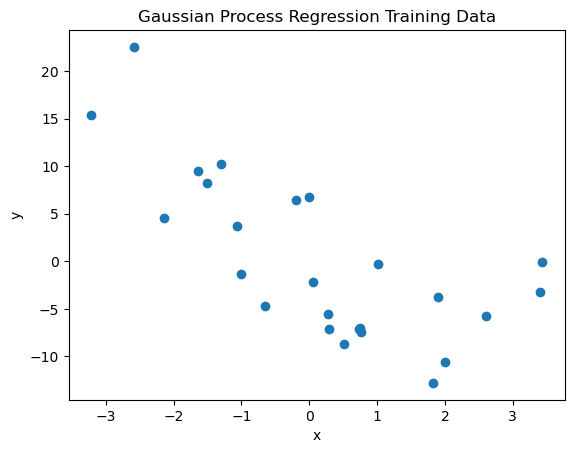

In [4]:
# Plot the training data
plt.scatter(df_gp['x'], df_gp['y'])
plt.title('Gaussian Process Regression Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We will use a Matern kernel with the value of $\nu=1.5$. This is its default value. We can also initialize the length-scale parameter at its default value of 1.0, so instantiating the Matern kernel with the syntax Matern() will create the Matern kernel for us. As with the code exmaple in the main text we will actually instantiate a Matern kernel using the syntax 1\*Matern(). The prefactor of 1 infront of the Matern constructor call introduces an extra parameter into our Matern kernel, in this case it is the parameter $A$, and we have initialized its value to 1. Again sklearn will optimize this parameter for us by fitting to the data.

We must also add a noise component to our kernel. This is the $\sigma^{2}\underline{\underline{I}}_{N}$ part of the overall covariance matrix. We do this by adding a sklearn WhiteKernel object to our Matern kernel. Again, sklearn will optimize the noise level parameter $\sigma^{2}$ when it fits to the data.    

In [5]:
# Specify our kernel
kernel = 1*Matern() + WhiteKernel(noise_level_bounds=(1.0, 20.0))

So now we have our kernel, we can create a Gaussian Process Regression object by calling the sklearn GaussianProcessRegressor constructor, passing in the kernel object we already created.

In [6]:
# Create GaussianProcessRegressor object which we will use to do our Gaussian Process Regression 
gaussian_process = GaussianProcessRegressor(kernel=kernel)

Now we can optimize the parameters $A, b, \sigma$ by calling the fit method of the GaussianProcessRegressor object, into which we pass our training data

In [7]:
# Optimize the model parameters
gaussian_process.fit(df_gp['x'].values.reshape(-1,1), df_gp['y'])

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1))

Let's take a look at the optimized parameters. We can do this by just looking at the kernel object

In [8]:
# Look at the kernel object after we have optimized it
gaussian_process.kernel_

9.03**2 * Matern(length_scale=0.585, nu=1.5) + WhiteKernel(noise_level=8.91)

We can see the optimized kernel is of the form $K\left (x_{i},x_{j}\right ) = 9.03^{2} \times {\rm Matern}\left (x_{i},x_{j} | b=0.585, \nu=1.5 \right ) + 8.91\times \delta_{ij}$. This means sklearn has chosen the optimal values as $A=9.03^{2}$, $b=0.585$ and $\sigma^{2}=8.91$. The values for the amplitude $A$, length-scale $b$, and noise-level $\sigma^{2}$ are not that different from the optimal values for $A=9.24^{2}, b=0.412, \sigma^{2}=8.33$ that we got when we used an RBF kernel on the same data. This is what we expected.

Having got our optimal GaussianProcessRegressor, let's use it to make some prediction. We make predictions for regularly spaced values of $x$ between the maximum and minimum values of $x$ seen in the training data set. The predictions are the expectation values of the response (target) variable at each of the prediction points. We'll also get the standard deviations of the response variable so we can plot confidence intervals around our predictions.

In [9]:
# Create a range of x values for prediction
x_predict = np.arange(df_gp['x'].min(), df_gp['x'].max(), 0.01).reshape(-1,1)

# Get the prediction (expectation) and standard deviation.
mean_prediction, std_prediction = gaussian_process.predict(x_predict, return_std=True)

We'll also calculate the true expectation values of the response variable at each of the prediction points. I can do this because I know the formula used to create the true expectation values of the response variable in training data.

In [10]:
# Calculate true expectation value
y_true = [(-3.4 - 2.0*x + (x-1.0)**2 + 5.5*np.sin(5.0*x-4.0))[0] for x in x_predict]

Finally we plot the predictions (estimates of the expectation values), the 95% confidence intervals and the true expectation values, and the training data points.

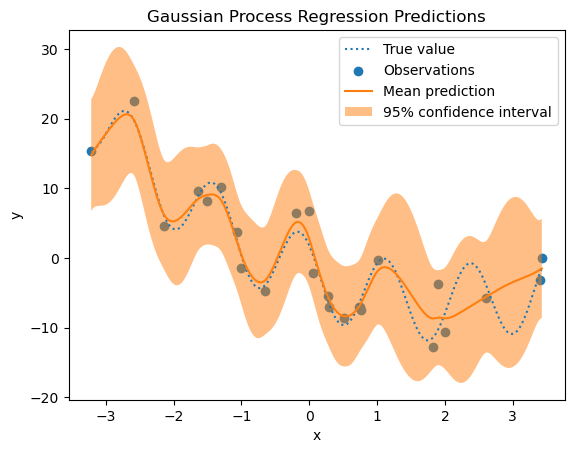

In [11]:
# Plot the predictions
plt.plot(x_predict, y_true, label="True value", linestyle="dotted")
plt.scatter(df_gp['x'], df_gp['y'], label="Observations")
plt.plot(x_predict, mean_prediction, label="Mean prediction")
plt.fill_between(
    x_predict.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.title('Gaussian Process Regression Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Unsurprisingly, the plot of the predictions is very similar to that which we got when we used an RBF kernel on the same data.

## Q2. Chinese Restaurant Process sampling from a DP posterior

We want to model the distribution from which the data in the file benford_data.csv (in the Data folder of the GitHib repository) was drawn. We'll put a DP prior on the distribution, which makes the posterior of the distribution also a DP. We'll then use the Chinese Restaurant process to sample new datasets from the posterior DP. First we'll read in the data.

In [12]:
# Read in the data
df_benford = pd.read_csv('../Data/benford_data.csv')

Let's take a quick look at the data

In [13]:
df_benford.head(5)

,x
0,1
1,2
2,7
3,7
4,1


The data contains a single column of integer valued observations. There are 50 observations in total. Now we'll set the NumPy pseudo-random number generator seed so that we can get reproducible results.

In [14]:
# Set the NumPy random number generator seed
np.random.seed(7454)

Next we'll define the base distribution we want to use. This is given by Eq.30 in Chapter 14.

In [15]:
# Create the DP prior base distribution probabilities
base_distribution = np.zeros(9)
for i in range(9):
    base_distribution[i] = np.log10(1.0 + (1.0/(1.0+i)))

Now to we need to define a couple of functions. The first function we define will run the Chinese Restaurant Process for us. The second function will calculate the posterior concentration parameter value and the posterior base distribution (according to Eq.26 in Chapter 14) and then pass these into our first function.

In [16]:
# Now define a function which will run the Chinese Restaurant sampling process
def sample_chinese_restaurant(alpha, base_distribution, n_sample):
    '''
    :param alpha: The concentration parameter
    :type alpha: float
    
    :param base_distribution: The base distribution probabilities
    :type base_distribution: A 1D numpy array
    
    :param n_sample: The length of the dataset to be generated
    :type n_sample: int
    
    :returns: An 1D array of sampled data values
    :rtype: A 1D numpy array
    '''
    
    # Initialize the sampled data array
    sampled_data = np.empty(n_sample)
    
    # Sample the first value from the base distribution
    sampled_data[0] = np.random.choice(a=range(1,10), p=base_distribution)
    
    # Now sample the remaining values
    for i in range(1,n_sample):
        # Decide if we are going to sample from the base distribution or not
        if np.random.rand() <= (alpha/(alpha+i-1.0)):
            sampled_data[i] = np.random.choice(a=range(1,10), p=base_distribution)
        else:
            sampled_data[i] = np.random.choice(a=sampled_data[0:i])
            
    return sampled_data

# Now define a function that sets the posterior effective concentration
# parameter and the posterior effective base distribution and then samples
# using the Chinese Restaurant process using those posterior effective
# quantities.
def sample_posterior_DP(alpha, base_distribution, n_sample, data):
    '''
    :param alpha: The concentration parameter
    :type alpha: float
    
    :param base_distribution: The base distribution probabilities
    :type base_distribution: A 1D numpy array
    
    :param n_sample: The length of the dataset to be generated
    :type n_sample: int
    
    :param data: The observed data values whose distribution we are modelling 
                 with the DP
    :type data: A pandas Series
    
    :returns: An 1D array of sampled data values
    :rtype: A 1D numpy array
    '''    
    
    # Set the posterior effective concentration parameter
    alpha_effective = alpha + data.shape[0]
    
    # Set the effective base distribution equal to the user-specified 
    # base distribution (multiplied by alpha/(alpha +N))
    base_distribution_effective = (alpha/alpha_effective)*base_distribution
    
    # Now add in the contribution to the effective base distribution that 
    # comes from the data
    for i in range(data.shape[0]):
        base_distribution_effective[int(data[i])-1] += (1.0/alpha_effective)
        
    # Sample using the Chinese Restaurant process and return
    return sample_chinese_restaurant(alpha=alpha_effective,
                                     base_distribution=base_distribution_effective,
                                     n_sample=n_sample)

Now we have defined those functions we can use then to generate 6 sampled datasets, each of length 100, sampled from the posterior DP.

In [17]:
# Set the number of sampled datasets required
n_posterior_samples = 6

# Set the length of each sampled dataset
posterior_sampled_data_length = 100

# Initialize the sampled data as an empty 2D array. 
# We will store the sampled data in the columns of this array
posterior_sampled_data = np.empty((posterior_sampled_data_length, n_posterior_samples))

# Now generate the sample data
# with a prior concentration parameter of alpha=10
for i in range(n_posterior_samples):
    posterior_sampled_data[:,i] = sample_posterior_DP(alpha=10,
                                                      base_distribution=base_distribution,
                                                      n_sample=posterior_sampled_data_length,
                                                      data=df_benford['x'])

We can now plot each of the posterior sampled datasets. We'll make barplots of the proportions of the integers 1 to 9 in each dataset. We'll also overplot the empirical distribution of the original dataset. To plot these various proportions we'll first define a function that calculates the proportions of the integers 1 to 9 present in a dataset.

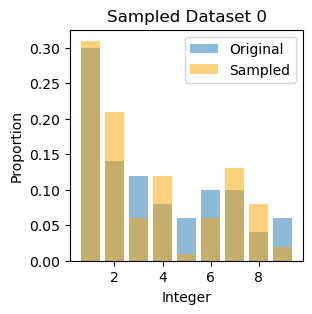

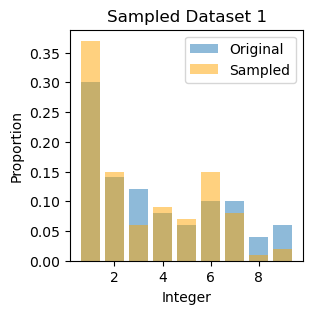

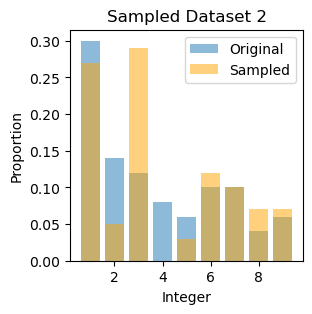

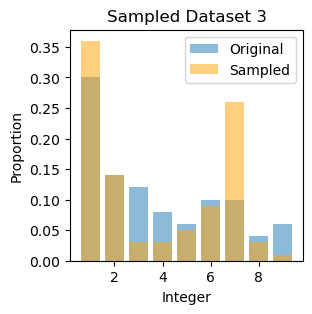

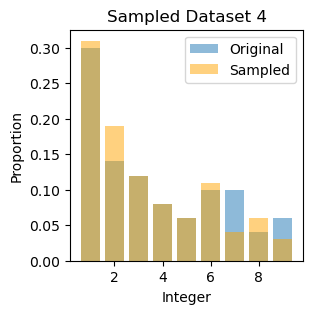

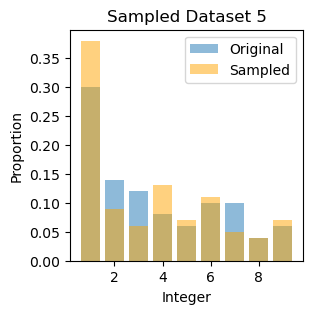

In [18]:
# Define a function to calculate the proportions 
# of the integers 1 to 9 that are present in an array
def calc_integer_proportions(x):
    proportions = np.zeros(9)
    
    for i in range(9):
        proportions[i] = np.sum(x==(i+1.0))/x.shape[0]
        
    return proportions

# Now let's plot our 6 posterior sampled datasets
for i in range(n_posterior_samples):
    fig = plt.figure(figsize=(3, 3))
    plt.bar(x=range(1,10), height=calc_integer_proportions(df_benford['x']), alpha=0.5, label="Original")
    plt.bar(x=range(1,10), height=calc_integer_proportions(posterior_sampled_data[:,i]), alpha=0.5, color='orange', label="Sampled")
    plt.title('Sampled Dataset ' + str(i))
    plt.xlabel("Integer")
    plt.ylabel('Proportion')
    plt.legend()
    plt.show()
    

We can see there is a lot of variation in the shapes of the different datasets we have sampled from the posterior DP, but they all roughly follow the shape of the distribution calculated from the original data. Have a play around with changing the prior concentration parameter $\alpha$ and also the length of the datasets sampled from the posterior DP (i.e. increase it or decrease it from 100) and see what effect this has upon the shape of the proportions we get for the posterior sampled datasets. Obviously the proportions of the various integers in the original data will remain unchanged even when we vary $\alpha$ or the length of the sampled datasets. 

You may have been wondering why we called the file that contained the original data, benford_data.csv, and why we used the unusual prior base distribution $P(X=x) = \log_{10}\left ( 1 + \frac{1}{x}\right )$. The answer is that the base distrbution is known as the Benford distribution. It is the distribution followed by the first significant digit of numbers in data from many different datasets. This phenomenon is known as Benford's law. Benford's law is a fascinating subject with a rich history. If you want to learn more about Benford's law see https://en.wikipedia.org/wiki/Benford%27s_law 